In [1]:
!nvidia-smi

Thu May  2 20:17:43 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:41:00.0 Off |                  Off |
| 32%   52C    P8             27W /  230W |       0MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 32  # the generated image resolution
    train_batch_size = 24
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 300
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 50
    save_image_epochs = 10
    # save_image_epochs = 1
    save_model_epochs = 30
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'ddpm-yosemite-256-latest'  # the model namy locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

In [4]:
from datasets import load_dataset

config.dataset_name = "imagefolder"
train_dataset_path = "ddpm-data/summer2winter_yosemite/train"
eval_dataset_path = "ddpm-data/summer2winter_yosemite/test"
train_dataset = load_dataset(config.dataset_name, data_dir=train_dataset_path, split="train")
eval_dataset = load_dataset(config.dataset_name, data_dir=eval_dataset_path, split="train")

Resolving data files:   0%|          | 0/2193 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/547 [00:00<?, ?it/s]

In [5]:
torch.cuda.is_initialized()

False

In [6]:
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 2193
})

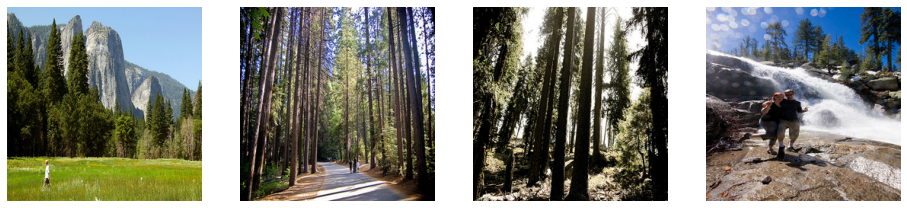

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(train_dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [8]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

/nfshomes/skarki/scratch/miniconda3/envs/llm/lib/python3.9/site-packages/transformers/utils/generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [9]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    labels = [l for l in examples["label"]]
    return {"images": images, "labels": labels}

train_dataset.set_transform(transform)
eval_dataset.set_transform(transform)

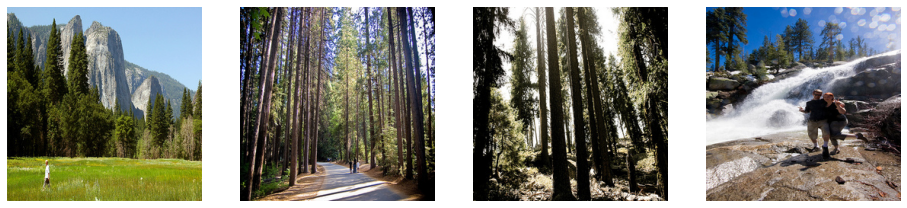

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(train_dataset[:4]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

In [11]:
import torch

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True)
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=config.train_batch_size, shuffle=False)
torch.cuda.is_initialized()

False

In [12]:
def setup_model(config, train_dataloader):
    from diffusers.optimization import get_cosine_schedule_with_warmup
    from diffusers import UNet2DModel
    from diffusers import DDIMScheduler
    from diffusers import AutoencoderKL
    
    unet = UNet2DModel(
        sample_size=config.image_size,  # the target image resolution
        in_channels=4,  # the number of input channels, 3 for RGB images
        out_channels=4,  # the number of output channels
        layers_per_block=2,  # how many ResNet layers to use per UNet block
        block_out_channels=(128, 128, 256, 512, 512),  # the number of output channels for each UNet block
        down_block_types=(
            "DownBlock2D",  # a regular ResNet downsampling block
            "DownBlock2D",
            "DownBlock2D",
            # "DownBlock2D",
            "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
            "DownBlock2D",
        ),
        up_block_types=(
            "UpBlock2D",  # a regular ResNet upsampling block
            "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
            # "UpBlock2D",
            "UpBlock2D",
            "UpBlock2D",
            "UpBlock2D"
        ),
        num_class_embeds=2
    )
    
    vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").eval()
    optimizer = torch.optim.AdamW(unet.parameters(), lr=config.learning_rate)

    lr_scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=config.lr_warmup_steps,
        num_training_steps=(len(train_dataloader) * config.num_epochs),
    )
    
    noise_scheduler = DDIMScheduler(
        beta_start=0.00085, 
        beta_end=0.012, 
        beta_schedule="scaled_linear", 
        clip_sample=False, 
        set_alpha_to_one=False
    )
    # noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
    return unet, vae, optimizer, lr_scheduler, noise_scheduler

torch.cuda.is_initialized()

False

In [13]:
import math
from PIL import Image

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

# def latents_to_pil(latents):     
#     '''     
#     Function to convert latents to images     
#     '''     
#     latents = (1 / 0.18215) * latents     
#     with torch.no_grad():         
#         image = vae.decode(latents).sample     
    
#     image = (image / 2 + 0.5).clamp(0, 1)     
#     image = image.detach().cpu().permute(0, 2, 3, 1).numpy()      
#     images = (image * 255).round().astype("uint8")     
#     pil_images = [Image.fromarray(image) for image in images]        
#     return pil_images

def latents_to_pil(vae, latents):     
    '''     
    Function to convert latents to images     
    '''     
    latents = (1 / 0.18215) * latents.to(vae.device)     
    with torch.no_grad():         
        image = vae.decode(latents).sample     
    
    image = (image / 2 + 0.5).clamp(0, 1)     
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()      
    images = (image * 255).round().astype("uint8")     
    pil_images = [Image.fromarray(image) for image in images]        
    return pil_images
    
def evaluate(config, epoch, pipeline, vae):
    class_labels = torch.randint(0, 2, (config.eval_batch_size,), device=pipeline._execution_device)
    latents = pipeline.get_noisy_atents(
        batch_size = config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
        class_labels=class_labels,
        output_type="pt"
    ).images
    images = latents_to_pil(vae, latents)
    
    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")


In [14]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami

from tqdm.auto import tqdm
from pathlib import Path
import os

def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

def train_loop(setup_model_fn, config, train_dataloader):

    from ddim import CustomDDIMPipeline
    
    unet, vae, optimizer, lr_scheduler, noise_scheduler = setup_model_fn(config, train_dataloader)
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        # log_with="tensorboard",
        # logging_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    unet, vae, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, vae, optimizer, train_dataloader, lr_scheduler
    )
    vae = accelerator.unwrap_model(vae)
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            _images = batch['images']
            class_labels = batch['labels']
            clean_images  = vae.encode(_images).latent_dist.sample() * 0.18215
            
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(unet):
                # Predict the noise residual
                noise_pred = unet(noisy_images, timesteps, class_labels=class_labels, return_dict=False)[0]
                # loss = F.mse_loss(noise_pred, noise)
                loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()
                
                accelerator.backward(loss)

                # accelerator.clip_grad_norm_(unet.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            # pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            # pipeline = DDIMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            pipeline = CustomDDIMPipeline(unet=accelerator.unwrap_model(unet), scheduler=noise_scheduler)
            
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline, vae)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)

/nfshomes/skarki/scratch/miniconda3/envs/llm/lib/python3.9/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [15]:
torch.cuda.is_initialized()

False

In [16]:
from accelerate import notebook_launcher
args = (setup_model, config, train_dataloader)

notebook_launcher(train_loop, args, num_processes=4)

Launching training on 4 GPUs.


/nfshomes/skarki/scratch/miniconda3/envs/llm/lib/python3.9/site-packages/diffusers/utils/outputs.py:64: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/nfshomes/skarki/scratch/miniconda3/envs/llm/lib/python3.9/site-packages/diffusers/utils/outputs.py:64: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/nfshomes/skarki/scratch/miniconda3/envs/llm/lib/python3.9/site-packages/diffusers/utils/outputs.py:64: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/nfshomes/skarki/scratch/miniconda3/envs/llm/lib/python3.9/site-packages/diffusers/utils/outputs.py:64: UserWarning: torch.utils._pytree._register_pytree_node i

  0%|          | 0/23 [00:00<?, ?it/s]

/nfshomes/skarki/scratch/miniconda3/envs/llm/lib/python3.9/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/nfshomes/skarki/scratch/miniconda3/envs/llm/lib/python3.9/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/nfshomes/skarki/scratch/miniconda3/envs/llm/lib/python3.9/site-packages/diffusers/configura

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])